In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv('Cyber-Threat-Intelligence-Custom-Data_new_processed.csv')


# Show first few rows and data info
print(df.head())
print(df.info())


      id                                               text  \
0    249  A cybersquatting domain save-russia[.]today is...   
1  14309  Like the Android Maikspy, it first sends a not...   
2  13996  While analyzing the technical details of this ...   
3  13600  (Note that Flash has been declared end-of-life...   
4  14364  Figure 21. Connection of Maikspy variants to 1...   

                                           relations  \
0  [{'from_id': 44658, 'id': 9, 'to_id': 44659, '...   
1  [{'from_id': 48531, 'id': 445, 'to_id': 48532,...   
2  [{'from_id': 48781, 'id': 461, 'to_id': 48782,...   
3  [{'from_id': 51688, 'id': 1133, 'to_id': 51689...   
4  [{'from_id': 51780, 'id': 1161, 'to_id': 44372...   

                                           diagnosis  \
0  The diagnosis is a cyber attack that involves ...   
1  The diagnosis is that the entity identified as...   
2  Diagnosis: APT37/Reaper/Group 123 is responsib...   
3  The diagnosis is a malware infection. The enti...   
4  T

In [4]:
# Separate features and target (assuming last column is target)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode target if categorical
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Encode categorical features if any
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Preprocessing complete.")


Preprocessing complete.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

target_col = 'label_1'
df = df.dropna(subset=[target_col])

X_text = df['text']
y = df[target_col]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Vectorize text feature
tfidf = TfidfVectorizer(max_features=5000)
X_vect = tfidf.fit_transform(X_text)

print(f"Features shape: {X_vect.shape}, Target shape: {y_encoded.shape}")


Features shape: (329, 2264), Target shape: (329,)


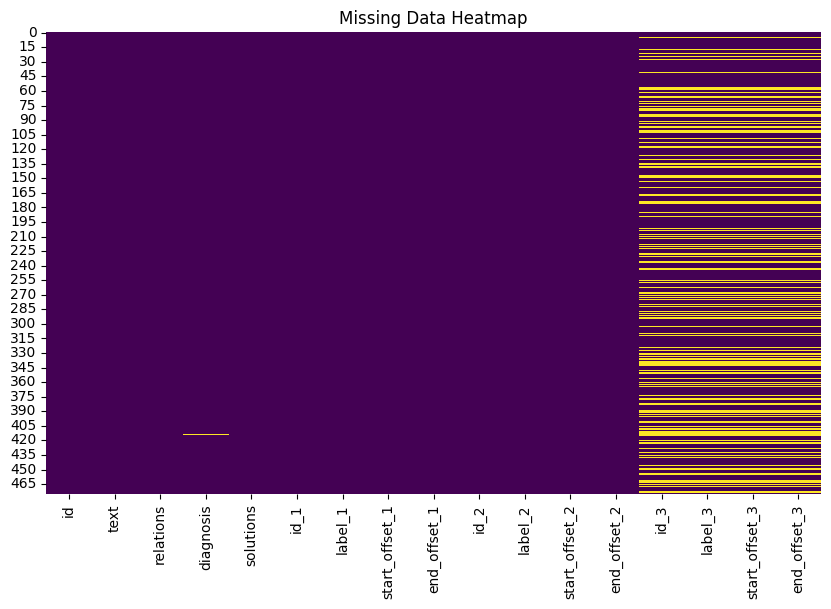

In [11]:
# Visualizing missing data (optional for better insight)
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [12]:
# ===============================
# ⚖️ Homogeneity Testing
# ===============================

# Importing necessary libraries for statistical tests
from scipy.stats import levene

In [13]:
# Selecting numerical columns for homogeneity testing
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

In [15]:
# Performing Levene's test for homogeneity
print("\n⚖️ Homogeneity Test Results:")
for column in numerical_columns:
    stat, p_value = levene(df[column].dropna(), df[numerical_columns[0]].dropna())
    print(f"Column: {column} | Statistic: {stat:.3f} | P-value: {p_value:.3f}")

    if p_value < 0.05:
        print(f"❌ {column} does not have homogeneous variance.")
    else:
        print(f"✅ {column} passes the homogeneity test.")


⚖️ Homogeneity Test Results:
Column: id | Statistic: 0.000 | P-value: 1.000
✅ id passes the homogeneity test.
Column: id_1 | Statistic: 80.663 | P-value: 0.000
❌ id_1 does not have homogeneous variance.
Column: start_offset_1 | Statistic: 270.413 | P-value: 0.000
❌ start_offset_1 does not have homogeneous variance.
Column: end_offset_1 | Statistic: 269.959 | P-value: 0.000
❌ end_offset_1 does not have homogeneous variance.
Column: id_2 | Statistic: 42.537 | P-value: 0.000
❌ id_2 does not have homogeneous variance.
Column: start_offset_2 | Statistic: 269.678 | P-value: 0.000
❌ start_offset_2 does not have homogeneous variance.
Column: end_offset_2 | Statistic: 269.234 | P-value: 0.000
❌ end_offset_2 does not have homogeneous variance.
Column: id_3 | Statistic: 16.815 | P-value: 0.000
❌ id_3 does not have homogeneous variance.
Column: start_offset_3 | Statistic: 184.557 | P-value: 0.000
❌ start_offset_3 does not have homogeneous variance.
Column: end_offset_3 | Statistic: 184.515 | P-va

In [16]:
# Proceed with data normalization or feature engineering based on test results.
print("\n✅ Missing data handling and homogeneity testing completed!")


✅ Missing data handling and homogeneity testing completed!


In [17]:
columns_to_normalize = ['bytes_out', 'response.code', 'dst_port']

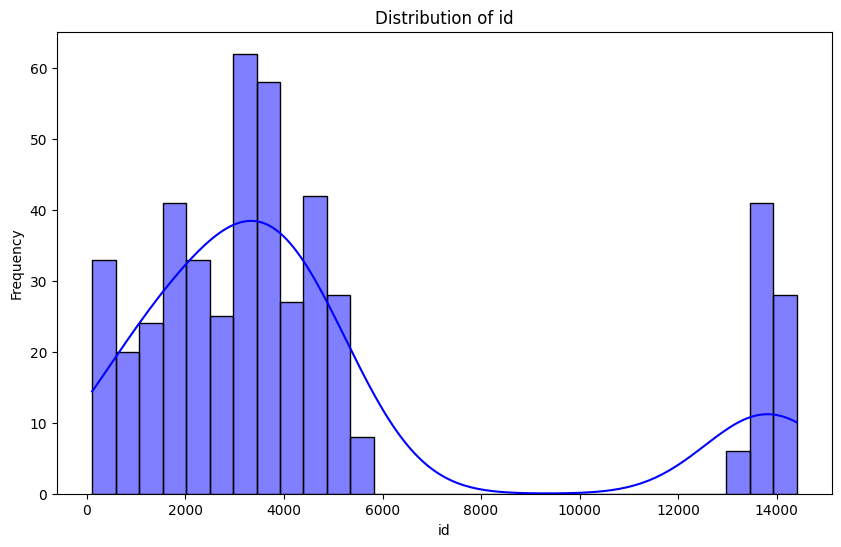

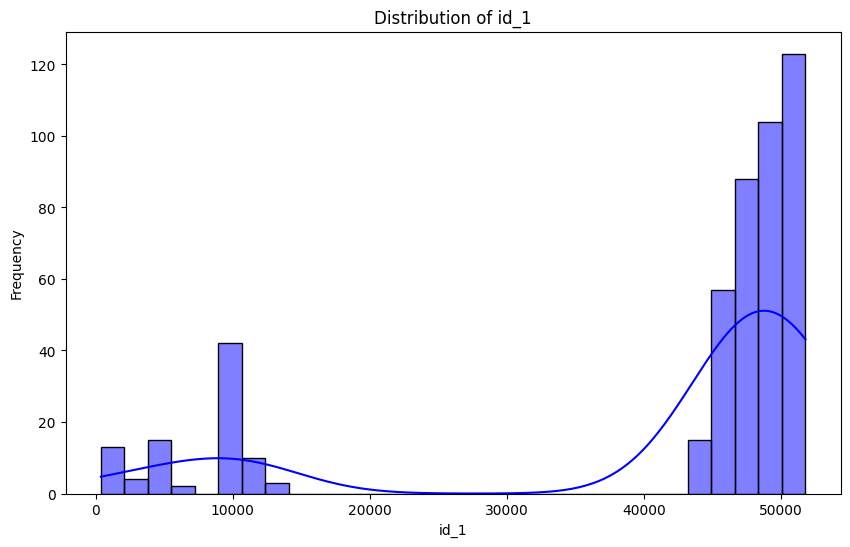

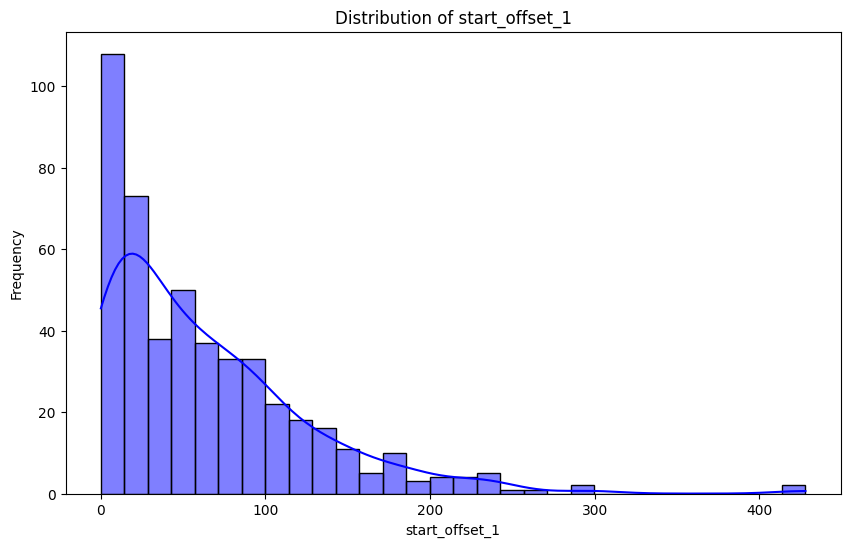

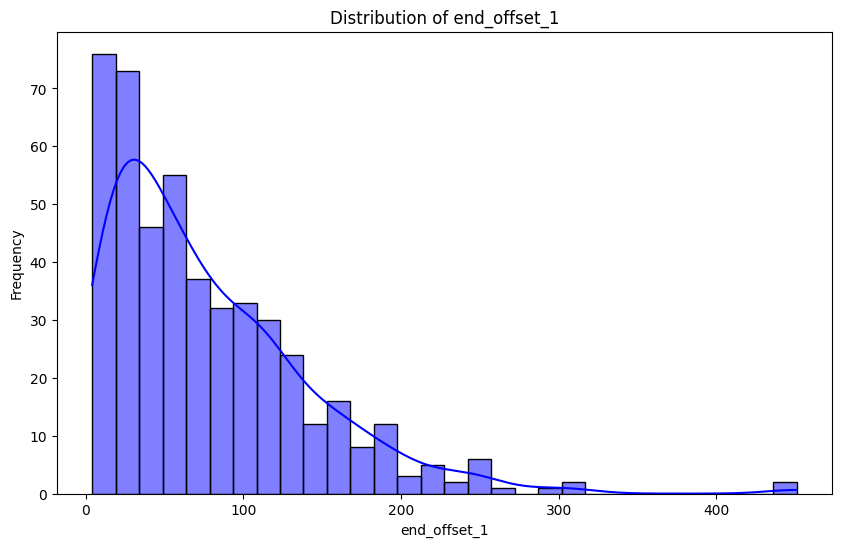

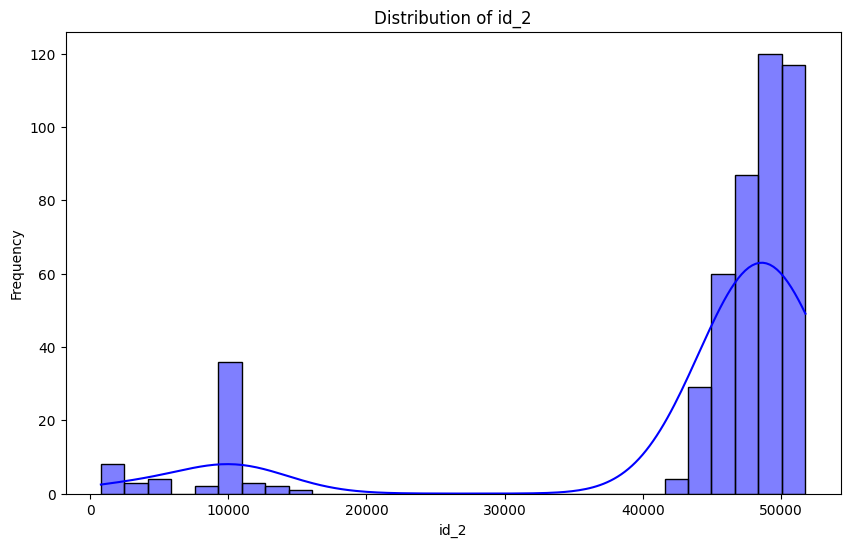

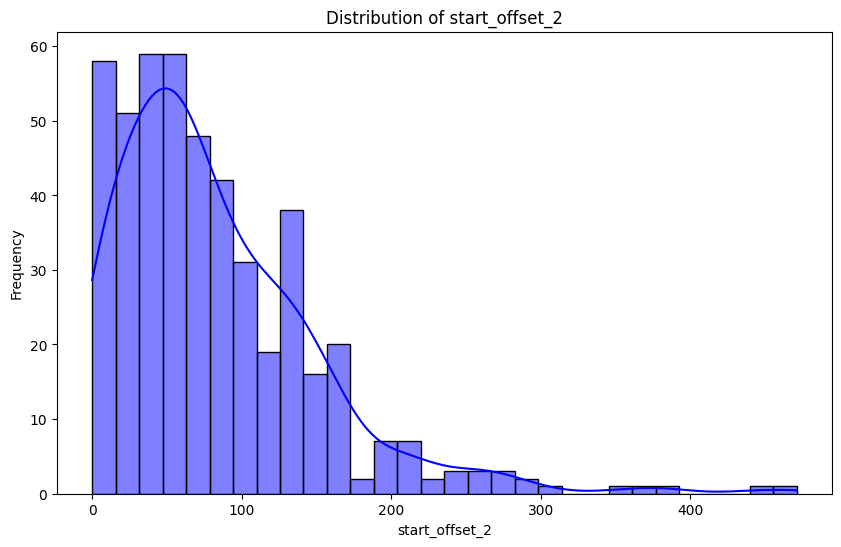

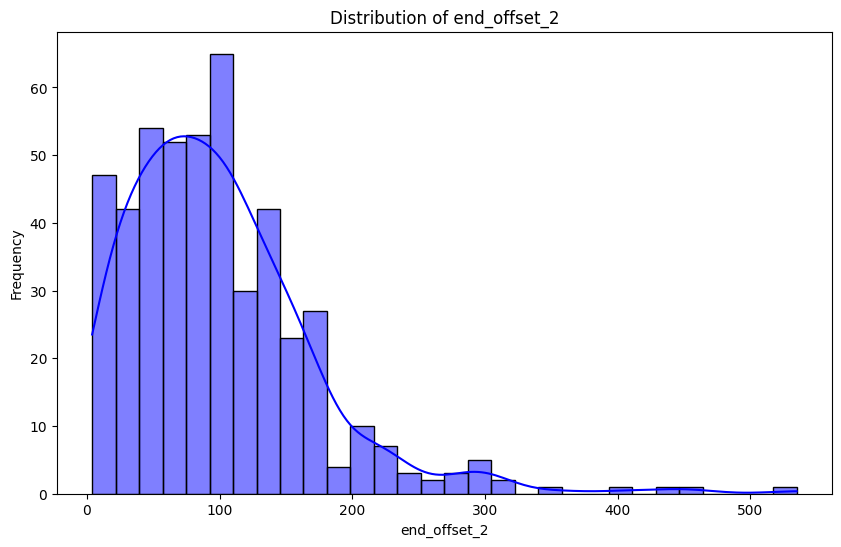

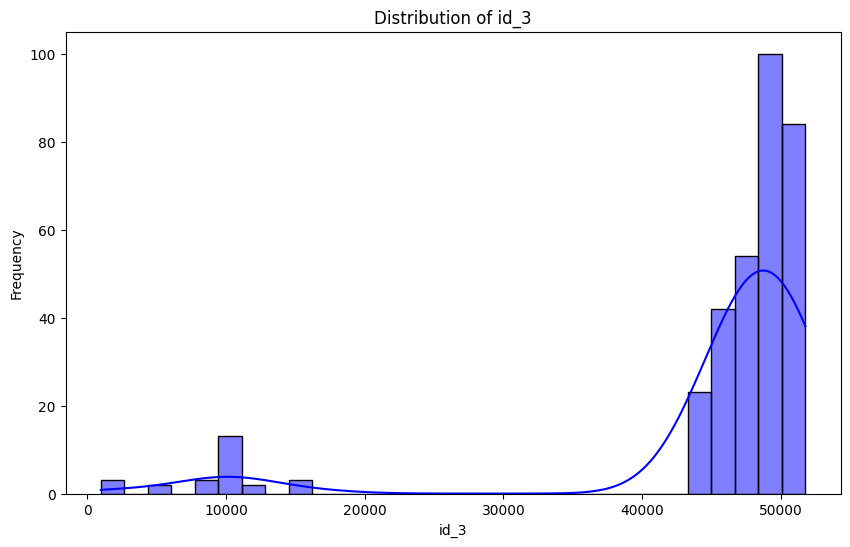

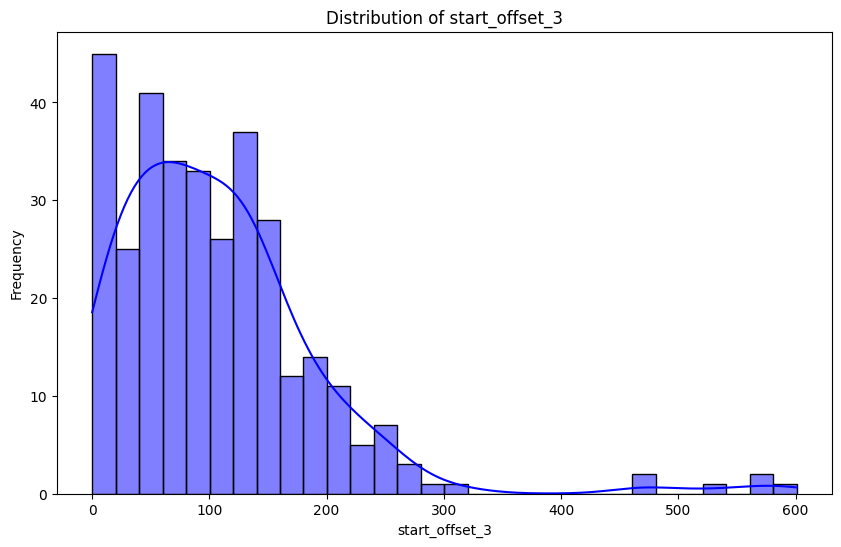

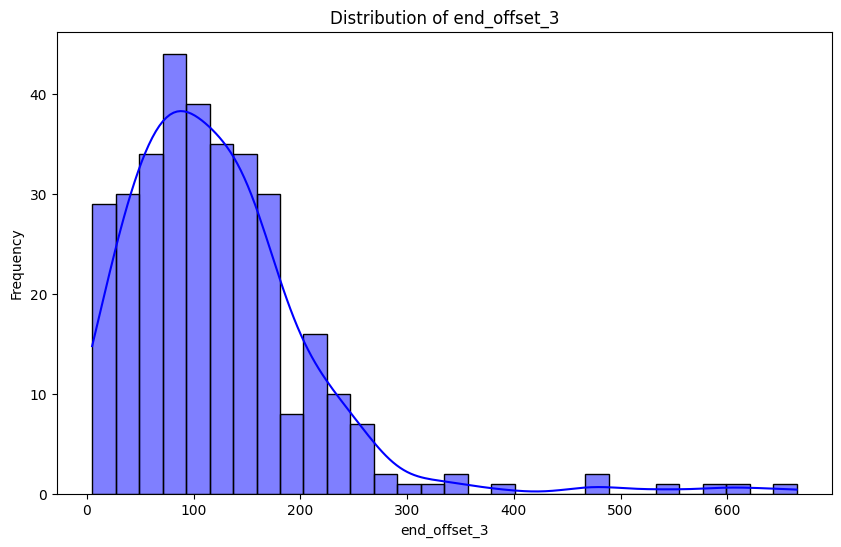

In [19]:
# Visualizing distributions for numerical features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

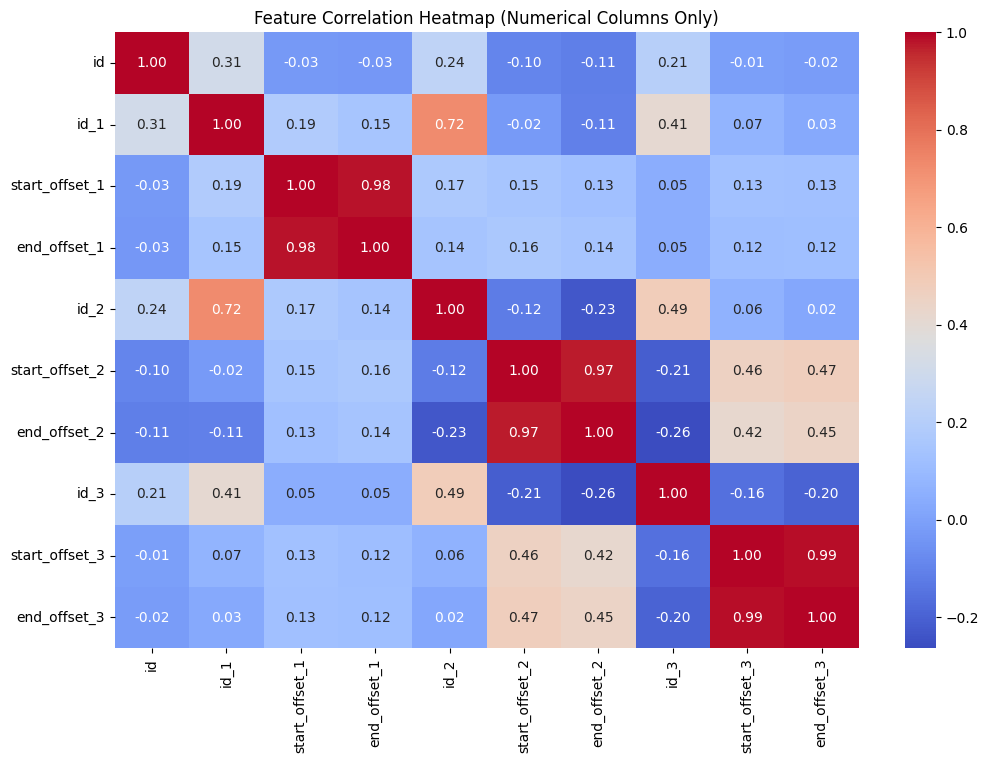

In [20]:
# Selecting only numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap (Numerical Columns Only)')
plt.show()

In [27]:
# Step 3: Encode Labels and Remove Rare Classes
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label_1'])

# Filter out labels with fewer than 2 occurrences
label_counts = df['label_encoded'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df = df[df['label_encoded'].isin(valid_labels)]

# Final text and label arrays
X_text = df['text']
y_encoded = df['label_encoded'].values


In [28]:
# Step 4: Vectorize Text Using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_vect = tfidf.fit_transform(X_text)


In [29]:
# Step 5: Train/Test Split (Now Stratified Safe)
X_train, X_test, y_train, y_test = train_test_split(
    X_vect, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 331, Testing samples: 143


In [30]:
# Step 6: Train Random Forest and SVM
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


In [31]:
# Step 7: Evaluate RF and SVM
print("🔍 Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\n🔍 SVM Results")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


🔍 Random Forest Results
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           2       1.00      0.50      0.67         2
           4       0.67      0.25      0.36         8
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         1
           7       0.78      0.54      0.64        13
           8       0.50      0.17      0.25         6
           9       1.00      0.25      0.40         4
          10       0.67      0.18      0.29        11
          11       1.00      0.29      0.44         7
          12       0.44      0.95      0.60        43
          13       0.58      0.35      0.44        20
          14       1.00      0.33      0.50         6
          15       1.00      1.00      1.00         2
          16       0.60      0.55      0.57        11

    accuracy                           0.53       143
   macro avg       0.68      0.39      0.45       143
we

C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [32]:
# Step 8: Train and Evaluate Stacking Classifier
estimators = [
    ('rf', rf),
    ('svm', svm)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(random_state=42),
    passthrough=True
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

print("\n🔍 Stacking Classifier Results")
print(classification_report(y_test, y_pred_stack))
print("Accuracy:", accuracy_score(y_test, y_pred_stack))


C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



🔍 Stacking Classifier Results
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           2       1.00      0.50      0.67         2
           4       0.50      0.25      0.33         8
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         1
           7       0.60      0.46      0.52        13
           8       0.50      0.17      0.25         6
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        11
          11       1.00      0.14      0.25         7
          12       0.45      0.93      0.61        43
          13       0.50      0.45      0.47        20
          14       1.00      0.33      0.50         6
          15       0.00      0.00      0.00         2
          16       0.64      0.82      0.72        11

    accuracy                           0.51       143
   macro avg       0.48      0.30      0.33      

C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kittu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

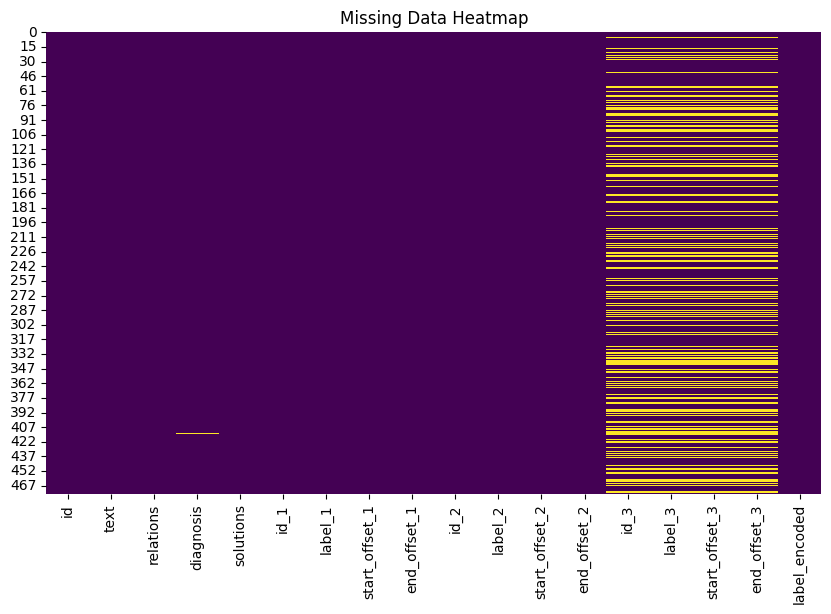

In [33]:
# Optional: Visualize Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


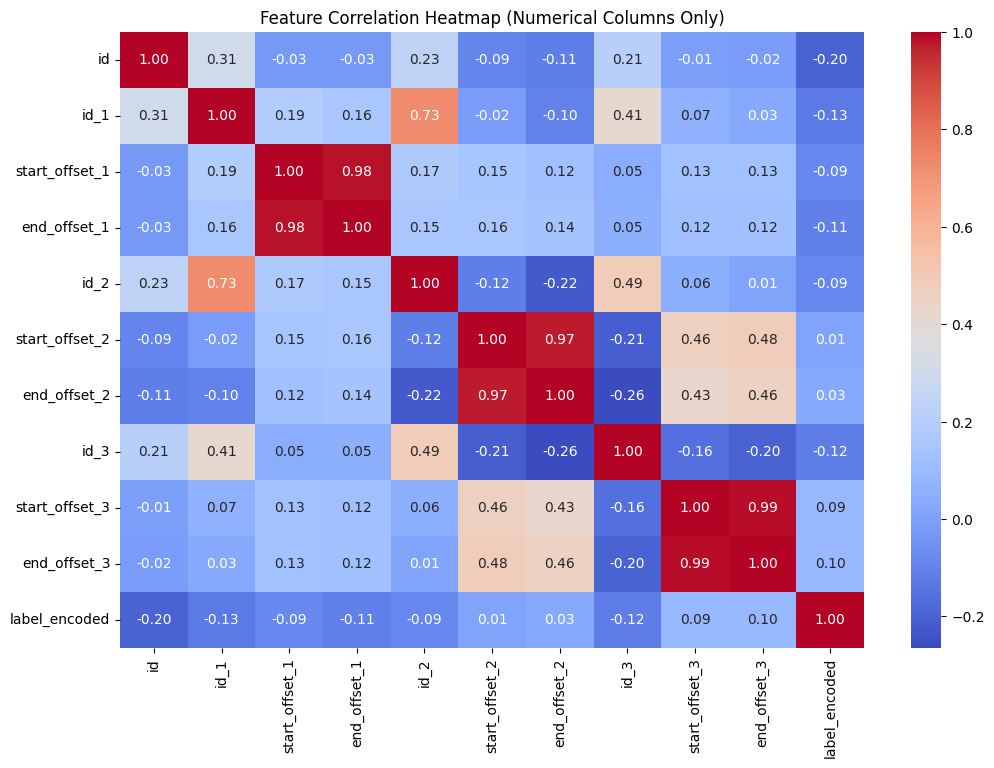

In [34]:
# Optional: Correlation Heatmap of Numeric Features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap (Numerical Columns Only)')
plt.show()


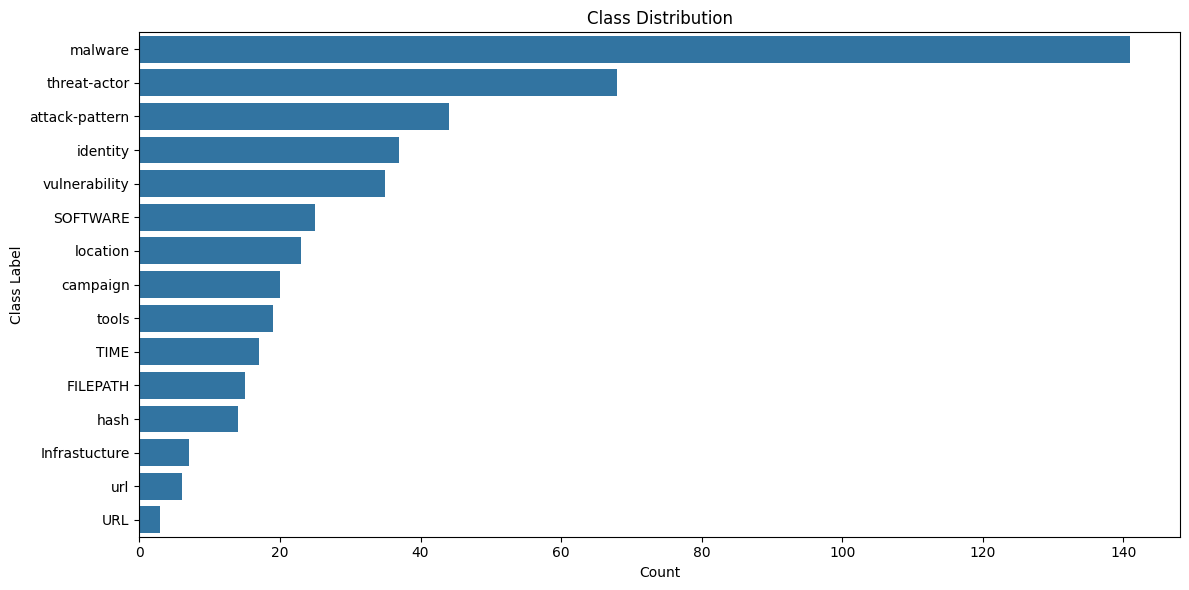

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Show distribution of original classes
plt.figure(figsize=(12, 6))
sns.countplot(y=df['label_1'], order=df['label_1'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.tight_layout()
plt.show()


C:\Users\kittu\AppData\Local\Temp\ipykernel_18052\788264829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(lambda x: len(x.split()))


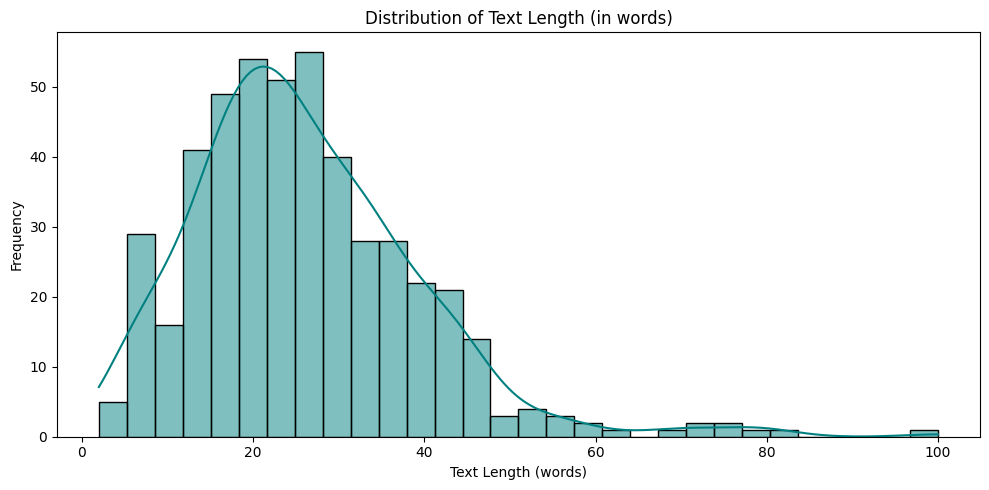

In [36]:
# Add a column for text length
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Plot text lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=30, kde=True, color='teal')
plt.title('Distribution of Text Length (in words)')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


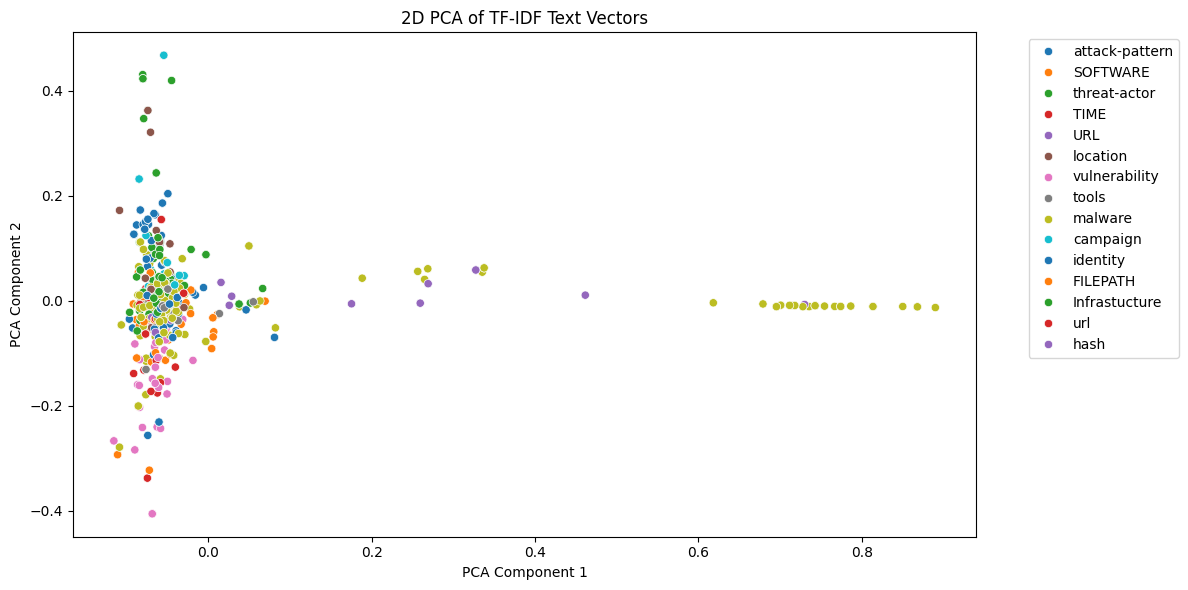

In [39]:
from sklearn.decomposition import PCA

# Reduce TF-IDF vectors to 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_vect.toarray())

# Plot PCA-reduced data
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=df['label_1'], palette='tab10', legend='full')
plt.title('2D PCA of TF-IDF Text Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

df = pd.read_csv('Cyber-Threat-Intelligence-Custom-Data_new_processed.csv')


In [13]:
from scipy.stats import zscore
import numpy as np

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    # Get the non-NA subset for the column
    col_data = df[col].dropna()
    
    # Calculate z-scores only on non-NA rows
    z_scores = zscore(col_data)
    
    # Get boolean mask of outliers
    outliers_mask = np.abs(z_scores) > 3
    
    # Use the index from col_data (non-NA rows) to get outliers from original df
    outliers = df.loc[col_data.index[outliers_mask]]
    
    print(f"Outliers detected in column '{col}':")
    print(outliers[[col]])
    print('-'*40)


Outliers detected in column 'id':
Empty DataFrame
Columns: [id]
Index: []
----------------------------------------
Outliers detected in column 'id_1':
Empty DataFrame
Columns: [id_1]
Index: []
----------------------------------------
Outliers detected in column 'start_offset_1':
     start_offset_1
10              257
338             428
361             297
410             428
433             297
----------------------------------------
Outliers detected in column 'end_offset_1':
     end_offset_1
317           291
338           451
361           307
410           451
433           307
----------------------------------------
Outliers detected in column 'id_2':
     id_2
42   1876
81    771
92   2074
96    974
319  1761
328  1766
346  2113
418  2113
----------------------------------------
Outliers detected in column 'start_offset_2':
     start_offset_2
107             301
213             444
217             385
250             352
296             471
317             375
-------------


⚠️ Outliers detected in 'id': 0


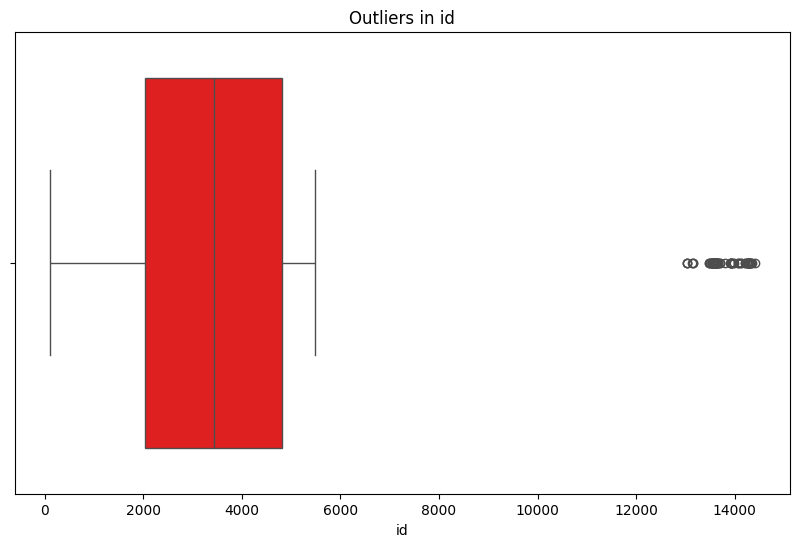


⚠️ Outliers detected in 'id_1': 0


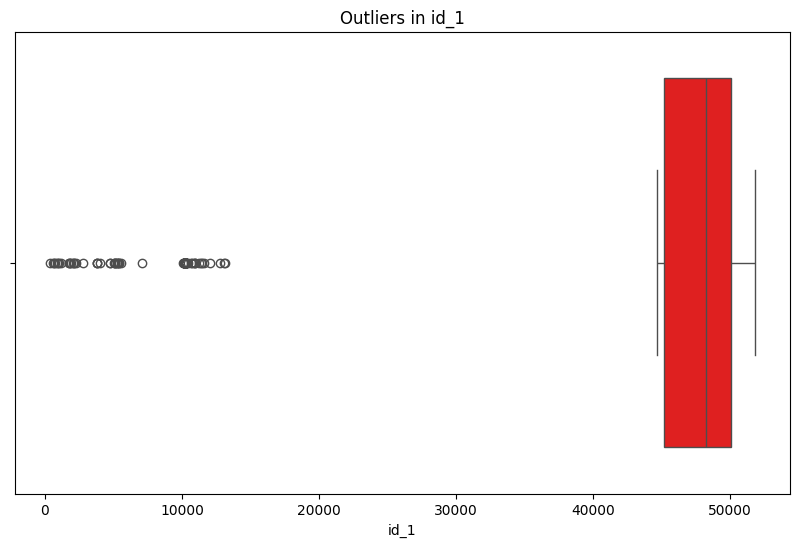


⚠️ Outliers detected in 'start_offset_1': 5


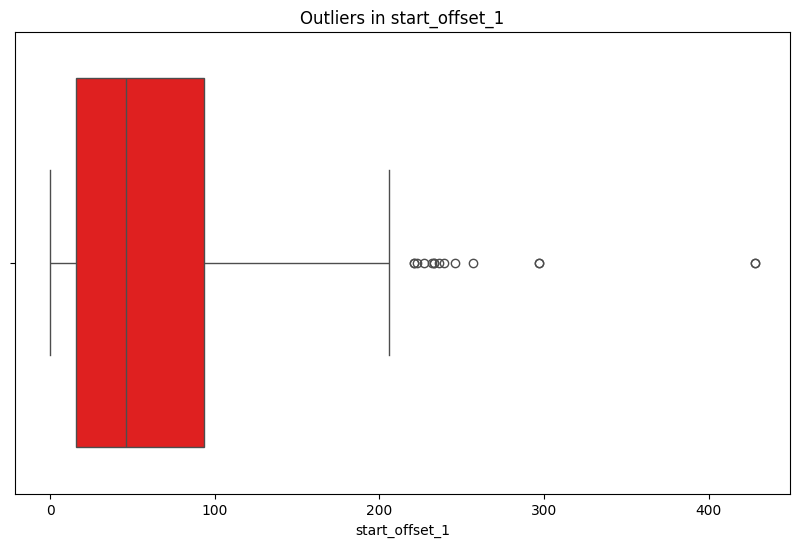


⚠️ Outliers detected in 'end_offset_1': 5


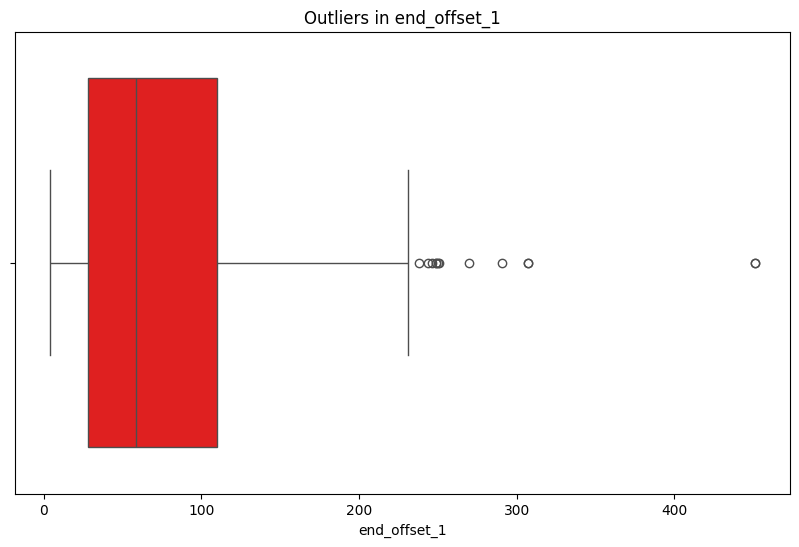


⚠️ Outliers detected in 'id_2': 8


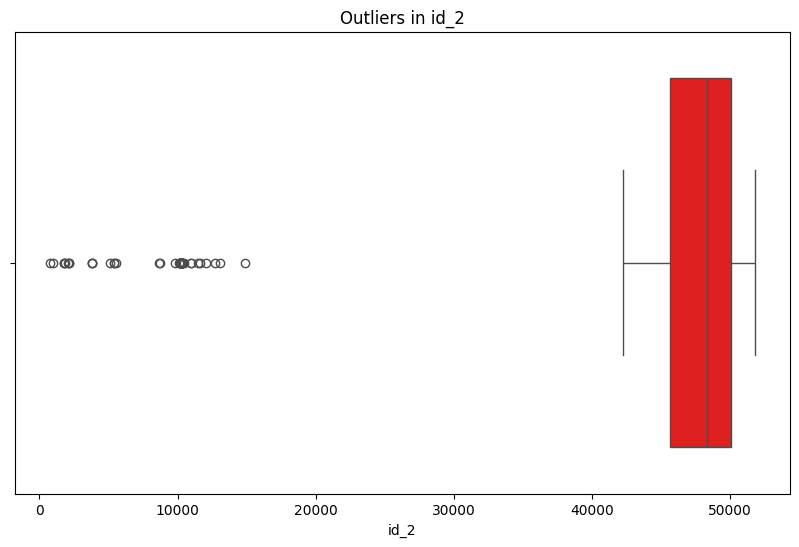


⚠️ Outliers detected in 'start_offset_2': 6


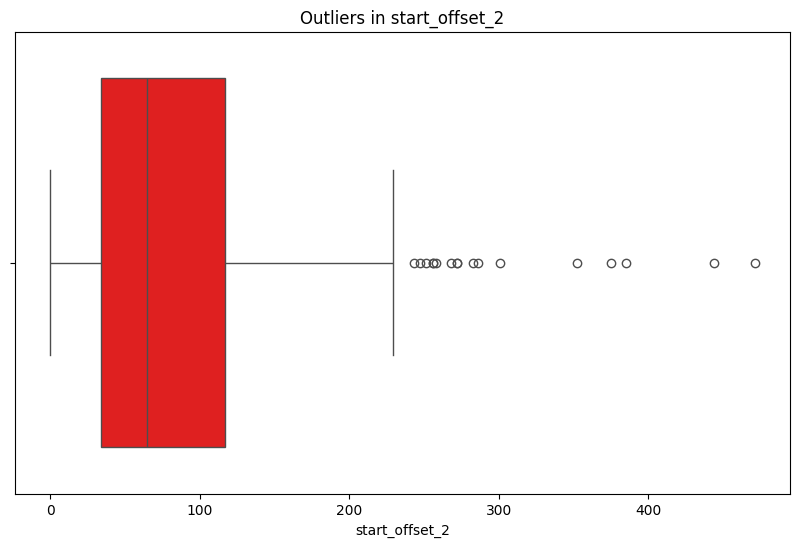


⚠️ Outliers detected in 'end_offset_2': 7


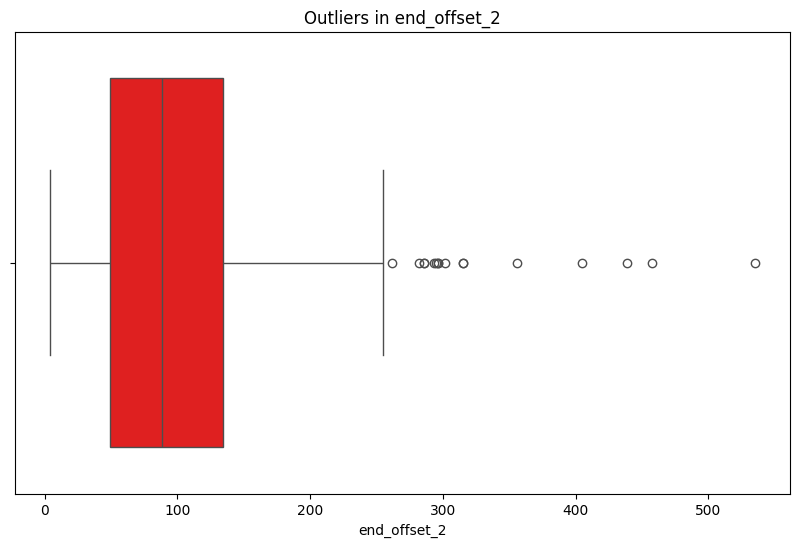


⚠️ Outliers detected in 'id_3': 23


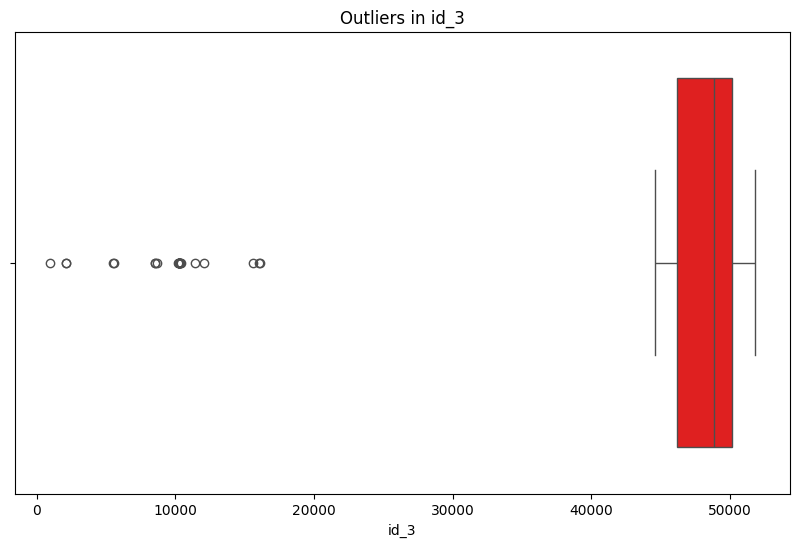


⚠️ Outliers detected in 'start_offset_3': 6


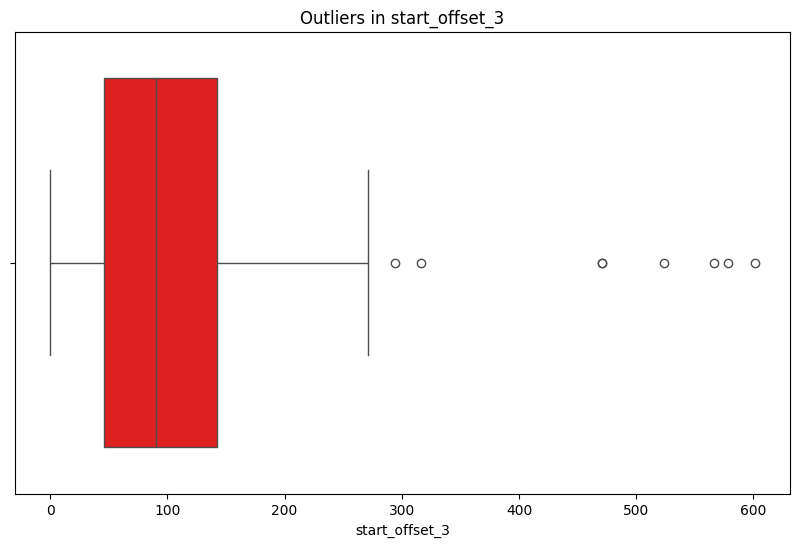


⚠️ Outliers detected in 'end_offset_3': 6


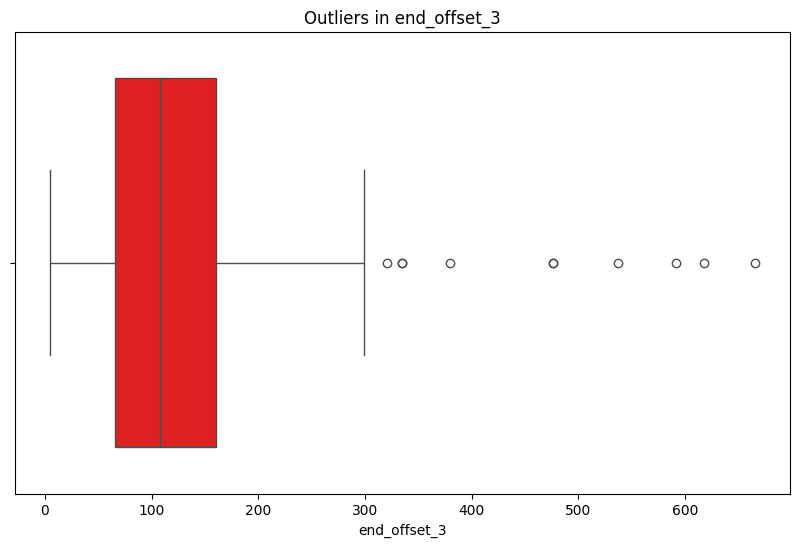

In [17]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    # Drop NaNs for z-score calculation
    col_data = df[col].dropna()
    
    # Calculate z-scores
    z_scores = zscore(col_data)
    
    # Find outliers using z-score threshold 3
    outlier_mask = np.abs(z_scores) > 3
    
    # Get the actual outlier rows from df using col_data's index
    outliers = df.loc[col_data.index[outlier_mask]]
    print(f"\n⚠️ Outliers detected in '{col}': {len(outliers)}")
    
    # Visualize with boxplot using full data (including outliers)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col], color="red")
    plt.title(f'Outliers in {col}')
    plt.show()


In [21]:
if 'time' in df.columns:
    data['time'] = pd.to_datetime(data['time'])

    plt.figure(figsize=(12, 6))
    sns.lineplot(df=df, x='time', y='bytes_in', label='Bytes In', color='blue')
    sns.lineplot(df=df, x='time', y='bytes_out', label='Bytes Out', color='orange')
    plt.title('Time-Based Trend Analysis')
    plt.xlabel('Time')
    plt.ylabel('Bytes')
    plt.legend()
    plt.show()

In [24]:

# Assuming you have your test features in X_test (DataFrame)
# and predictions in y_pred (array or Series)

# Combine predictions and features into one DataFrame
results_df = X_test.copy()
results_df['predicted_label'] = y_pred

# Calculate average (mean) values of numerical features grouped by predicted_label
summary_stats = results_df.groupby('predicted_label').mean()

print(summary_stats)


NameError: name 'summary_stats' is not defined